# MLP for regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=DataConversionWarning)

seed = 264

### Load and split dataset

In [2]:
# The data is already processed, 
# see https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset
dataset = load_diabetes()
X = dataset.data
Y = dataset.target
(n_samples, n_features) = X.shape

# Extract test set from entire dataset
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=seed)

print("Training dataset size (incl. validation):   ", len(X_train_val))
print("Test dataset size:                          ", len(X_test))

Training dataset size (incl. validation):    353
Test dataset size:                           89


### Visualize data

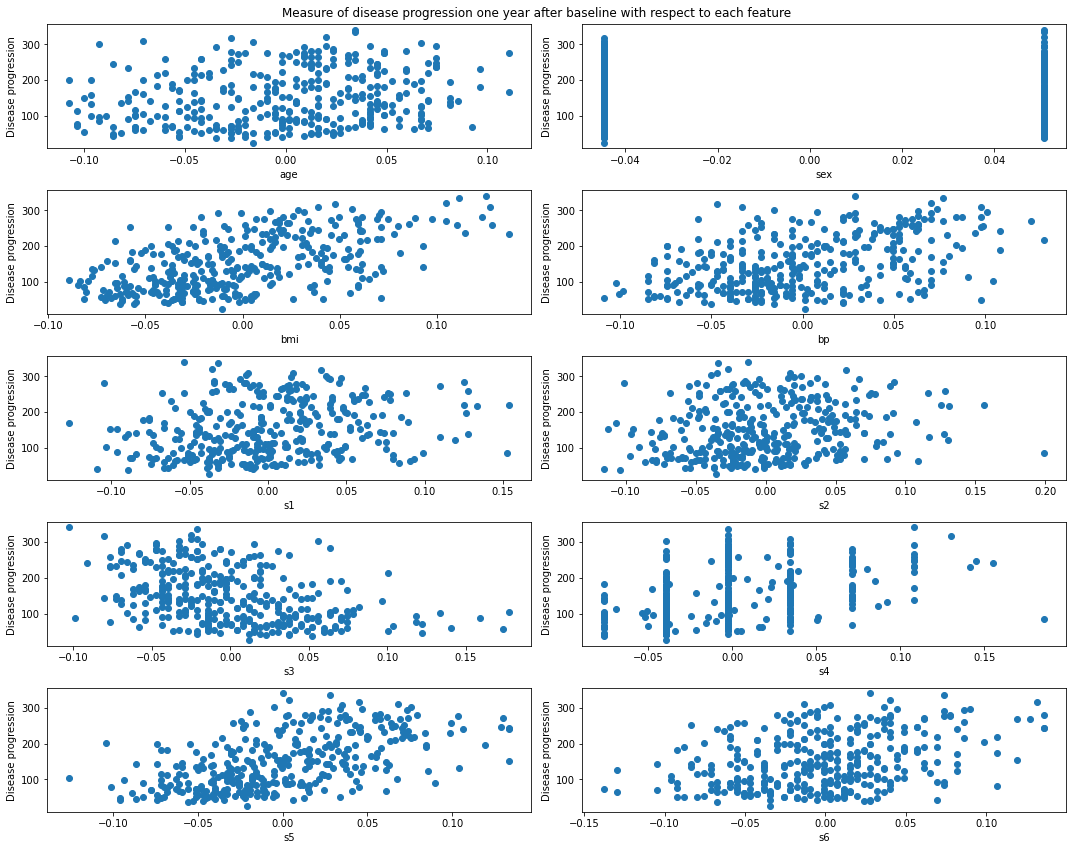

In [3]:
# Scatterplots of target with respect to each feature:
fig, axes = plt.subplots(5, 2, figsize=(15, 12), tight_layout=True)
for i, ax in enumerate(axes.flat[:n_features]) :
    ax.scatter(X_train_val[:,i], Y_train_val, marker='o')
    ax.set_xlabel(dataset.feature_names[i])
    ax.set_ylabel('Disease progression')
fig.suptitle("Measure of disease progression one year after baseline with respect to each feature")
plt.show()

### Preprocess data

In [4]:
# Remove sex and s4 from set of features
X_train_val = X_train_val[:,[i for i in range(n_features) if dataset.feature_names[i] not in ["sex", "s4"]]]
X_test = X_test[:,[i for i in range(n_features) if dataset.feature_names[i] not in ["sex", "s4"]]]

X_min_max_scaler = MinMaxScaler()
X_train_val = X_min_max_scaler.fit_transform(X_train_val)
X_test = X_min_max_scaler.transform(X_test)

Y_min_max_scaler = StandardScaler()
Y_train_val = Y_min_max_scaler.fit_transform(Y_train_val.reshape(-1, 1))
Y_test = Y_min_max_scaler.transform(Y_test.reshape(-1, 1))

# Create train/validation kfolds splitter
KFold_splitter = KFold(n_splits=10, shuffle=True, random_state=seed)
X_train_folds = []
X_val_folds = []
Y_train_folds = []
Y_val_folds = []

# Split train_val dataset into folds
for (kth_fold_train_idxs, kth_fold_val_idxs) in KFold_splitter.split(X_train_val, Y_train_val):
    X_train_folds.append(X_train_val[kth_fold_train_idxs])
    X_val_folds.append(X_train_val[kth_fold_val_idxs])
    Y_train_folds.append(Y_train_val[kth_fold_train_idxs])
    Y_val_folds.append(Y_train_val[kth_fold_val_idxs])

print("Number of features kept: ", X_test.shape[-1])
print("Training dataset size:   ", len(X_train_folds[0]))
print("Validation dataset size: ", len(X_val_folds[0]))
print("Test dataset size:       ", len(X_test))

Number of features kept:  8
Training dataset size:    317
Validation dataset size:  36
Test dataset size:        89


### Build different MLP models

In [5]:
# Create the list of hyper-parameters instances:
layers = [(10,), (50,), (5, 5), (10, 5, 5)]
momentums = [0, 0.9]
solvers = ["adam", "lbfgs"]
learning_rates = [0.1, 0.01, 0.001]

hparams = [
    {
        "hidden_layer_sizes" : l,
        "momentum": m, 
        "solver": s,
        "learning_rate_init" : r
    } for l in layers for m in momentums for s in solvers for r in learning_rates
]

print("Number of combinations to try:", len(hparams))

Number of combinations to try: 48


### Training: helper functions

In [6]:
def evaluate(model, X, Y):
    """
    Evaluate (already trained) model performance on the given dataset

    'metric' is a performance metric, a python function comparing 'Y' and 'Y_pred'
    """
    Y_pred = model.predict(X)
    perf = mean_squared_error(Y, Y_pred)
    return perf

### Training: train all models

In [7]:
train_mean_perfs = []
val_mean_perfs = []

# Loop over sets of model and hyperparameters:
for hparam in hparams:
    print("\nUsing hyper-parameters:", hparam)

    train_perfs = []
    val_perfs = []

    # Extra loop for the cross validation
    for X_trainf, X_valf, Y_trainf, Y_valf in zip(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds):

        # Instantiate model with current set of hyperparameter
        model = MLPRegressor(**hparam)

        # Train model
        model.fit(X_trainf, Y_trainf)

        # Compute train and validation loss
        train_perf = evaluate(model, X_trainf, Y_trainf)
        val_perf = evaluate(model, X_valf, Y_valf)

        train_perfs.append(train_perf)
        val_perfs.append(val_perf)

    # Compute mean performance for this set of hyperparameters
    train_mean_perf = np.mean(train_perfs)
    val_mean_perf = np.mean(val_perfs)
    print("Training mean MSE:    %.4f" %train_mean_perf)
    print("Validation mean MSE:  %.4f" %val_mean_perf)

    # Store info about this set of hyperparameters
    train_mean_perfs.append(train_mean_perf)
    val_mean_perfs.append(val_mean_perf)


Using hyper-parameters: {'hidden_layer_sizes': (10,), 'momentum': 0, 'solver': 'adam', 'learning_rate_init': 0.1}
Training mean MSE:    0.5077
Validation mean MSE:  0.5370

Using hyper-parameters: {'hidden_layer_sizes': (10,), 'momentum': 0, 'solver': 'adam', 'learning_rate_init': 0.01}
Training mean MSE:    0.4966
Validation mean MSE:  0.5453

Using hyper-parameters: {'hidden_layer_sizes': (10,), 'momentum': 0, 'solver': 'adam', 'learning_rate_init': 0.001}
Training mean MSE:    0.5920
Validation mean MSE:  0.5995

Using hyper-parameters: {'hidden_layer_sizes': (10,), 'momentum': 0, 'solver': 'lbfgs', 'learning_rate_init': 0.1}
Training mean MSE:    0.4523
Validation mean MSE:  0.5625

Using hyper-parameters: {'hidden_layer_sizes': (10,), 'momentum': 0, 'solver': 'lbfgs', 'learning_rate_init': 0.01}
Training mean MSE:    0.4485
Validation mean MSE:  0.5688

Using hyper-parameters: {'hidden_layer_sizes': (10,), 'momentum': 0, 'solver': 'lbfgs', 'learning_rate_init': 0.001}
Training me

### Select the best model

In [8]:
i_best = np.argmin(val_mean_perfs)
best_model = MLPRegressor(**hparams[i_best])
print("\nBest model selected, with hyperparameters", hparams[i_best])


Best model selected, with hyperparameters {'hidden_layer_sizes': (10,), 'momentum': 0.9, 'solver': 'adam', 'learning_rate_init': 0.01}


### Evaluate the best model

In [9]:
# Train on the entire training/validation dataset
best_model.fit(X_train_val, Y_train_val)

# Evaluate performance
train_val_mse = evaluate(best_model, X_train_val, Y_train_val)
test_mse = evaluate(best_model, X_test, Y_test)

print("\nSelected model MSE:")
print("Training (incl val):   %.4f" %train_val_mse)
print("Test:                  %.4f" %test_mse)


Selected model MSE:
Training (incl val):   0.4903
Test:                  0.5728


### Plot predictions

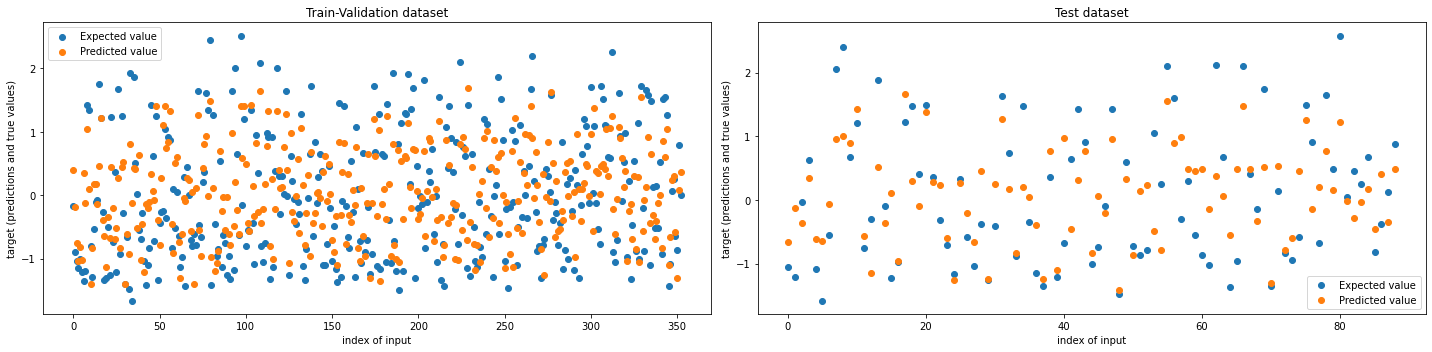

In [10]:
X_data = [X_train_val, X_test]
Y_data = [Y_train_val, Y_test]
dataset_types = ["Train-Validation", "Test"]

fig, axes = plt.subplots(1, 2, figsize=(20,5), tight_layout=True)
for inputs, true_values, dataset_type, ax in zip(X_data, Y_data, dataset_types, axes.flat):
    preds = best_model.predict(inputs)
    N = len(inputs)
    ax.set_title(dataset_type + " dataset")
    ax.scatter(np.arange(N), true_values, label="Expected value")
    ax.scatter(np.arange(N), preds, label="Predicted value")
    ax.set_xlabel("index of input")
    ax.set_ylabel("target (predictions and true values)")
    ax.legend()

### Plot features that gave the best/worst predictions

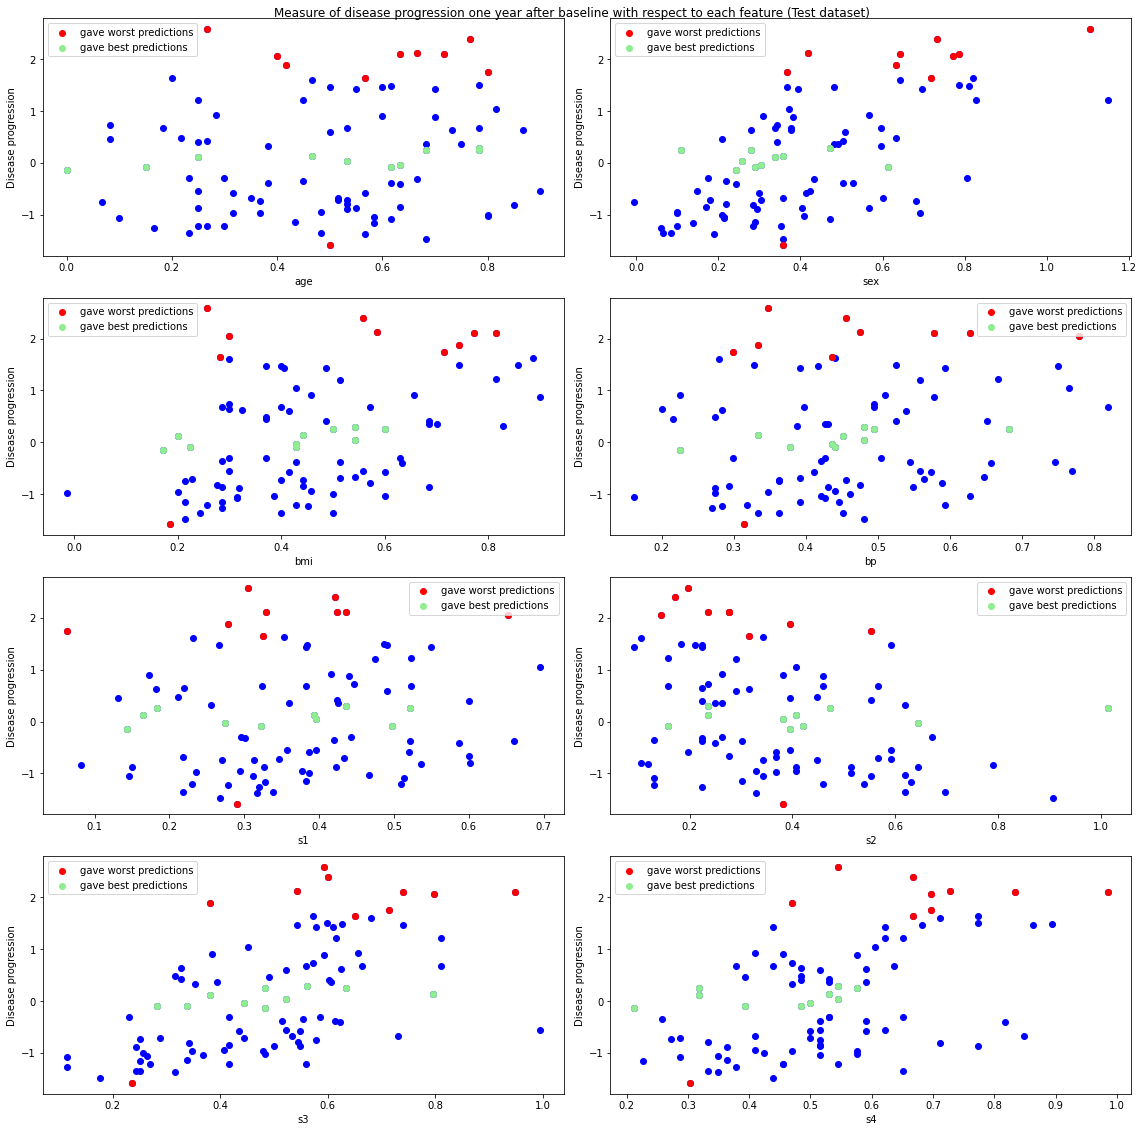

In [11]:
Y_pred = best_model.predict(X_test)
idx = np.argsort(np.sum((Y_pred-Y_test)**2, axis=1))
N = 10
best_x = X_test[idx[:N]]
worst_x = X_test[idx[-N:]]
best_y = Y_test[idx[:N]]
worst_y = Y_test[idx[-N:]]

# Scatterplots of target with respect to each feature:
fig, axes = plt.subplots(4, 2, figsize=(16, 16), tight_layout=True)
for i, ax in enumerate(axes.flat[:n_features]) :
    ax.scatter(X_test[:,i], Y_test, c="b")
    ax.scatter(worst_x[:,i], worst_y, c="r", label="gave worst predictions")
    ax.scatter(best_x[:,i], best_y, c="lightgreen", label="gave best predictions")
    ax.set_xlabel(dataset.feature_names[i])
    ax.set_ylabel('Disease progression')
    ax.legend()
fig.suptitle("Measure of disease progression one year after baseline with respect to each feature (Test dataset)")

plt.show()